# Dragging gestures: Analysis

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [19]:
funcIoDs = json.load(open('curvature_integrals.json'))

In [20]:
df = pd.read_csv('logs.csv')

print("Columns:", df.columns)
# indices of important columns
prAgeInd = 1
deviceInd = 2
testModeInd = 3
funcIdInd = 5
funcDiffInd = 6
funcProjInd = 7
drawTimeInd = 8

test0data = df[df['Test mode'] == 0]
test1data = df[df['Test mode'] == 1]

PROJECTIONS = ['Cartesian', 'Polar']
FUNC_IDS = [0, 1, 2, 3, 4, 5]
DEVICES = ['Mouse', 'Graphic tablet']
TEST_MODES = [0, 1]

def getIodsAsArray(projections, experimentModes):
    iodsArr = []
    for experimentMode in experimentModes:
        for projection in projections:            
            test = 0
            if projection == 'Cartesian' and experimentMode == 1:
                test = 1
            elif projection == 'Polar' and experimentMode == 0:
                test = 2
            elif projection == 'Polar' and experimentMode == 1:
                test = 3
    
            # iod = index of difficulty
            iods = funcIoDs[str(test)]
    
            for iod in iods:
                iodsArr.append(float(iods[iod]))
    return iodsArr

Columns: Index(['Participant name', 'Participant age', 'Device', 'Test mode',
       'Logging timestamp', 'Function ID', 'Function difficulty',
       'Function projection', 'Drawing time', 'Error approx', 'Is Left handed',
       'Experienced Graphic Tablet User'],
      dtype='object')


# Drawing time distribution per function

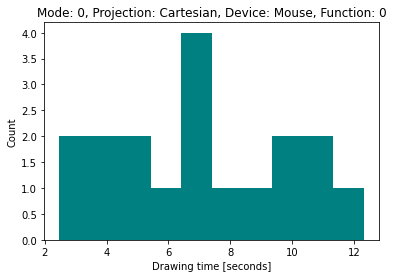

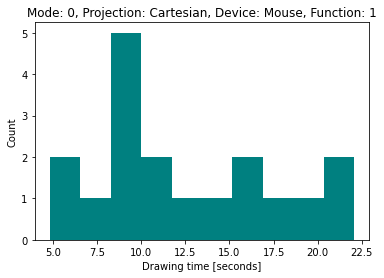

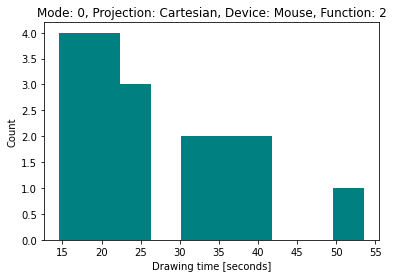

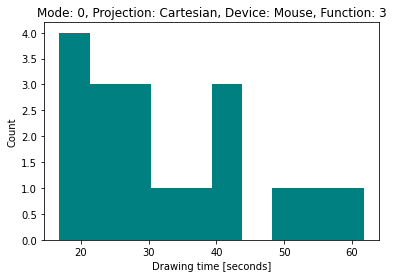

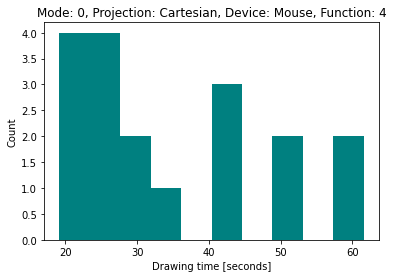

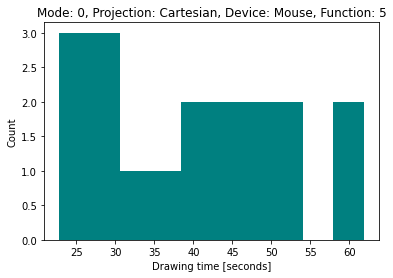

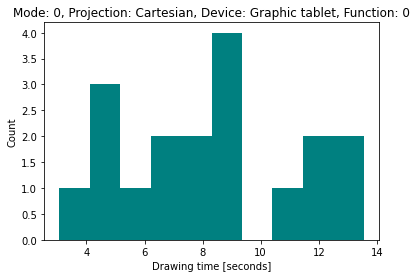

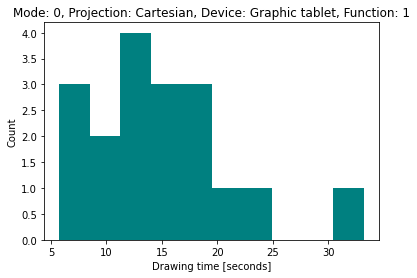

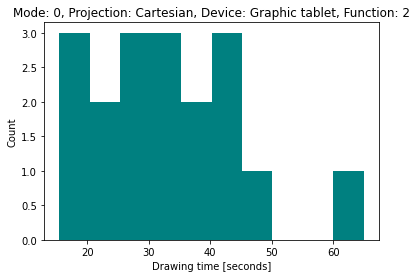

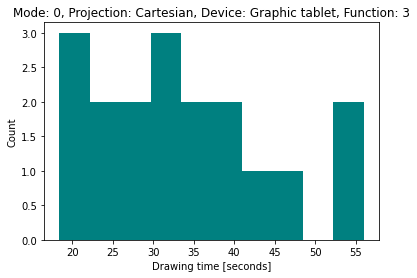

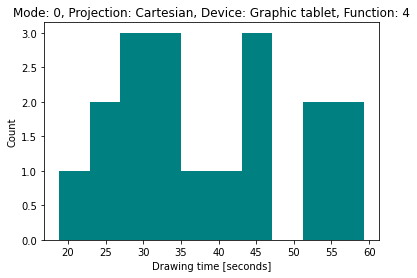

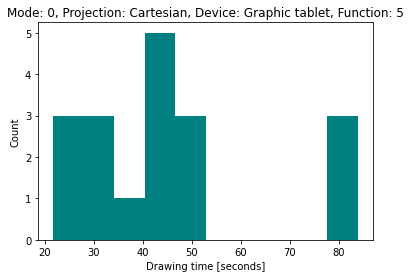

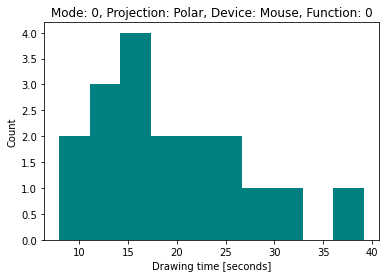

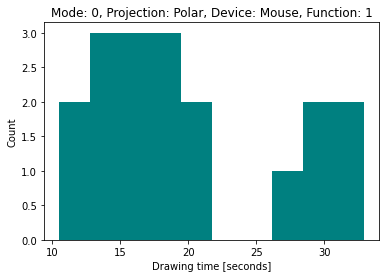

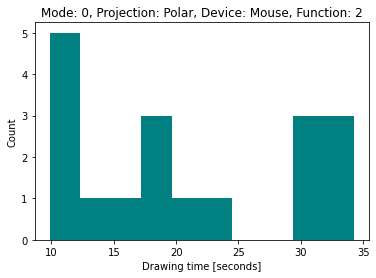

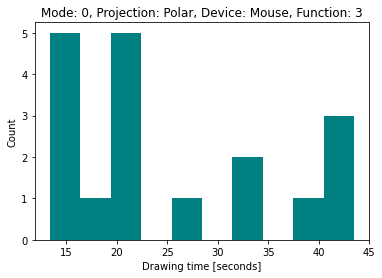

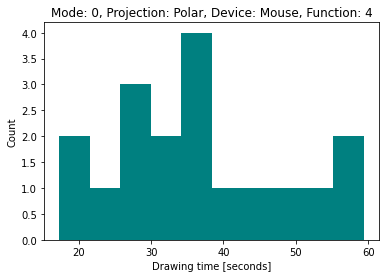

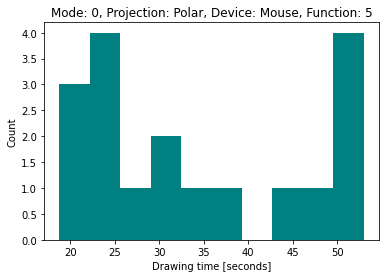

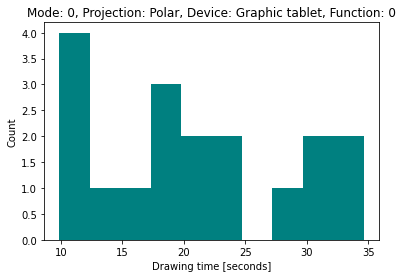

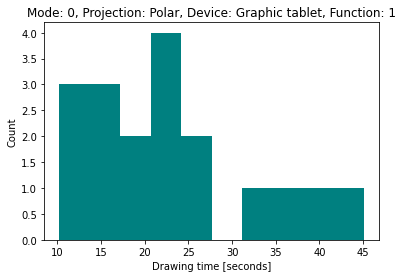

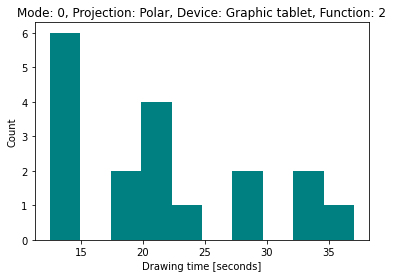

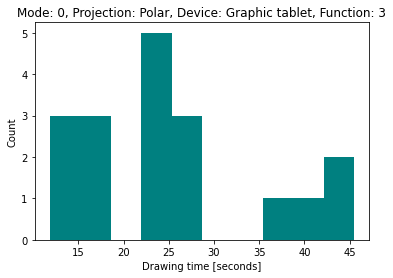

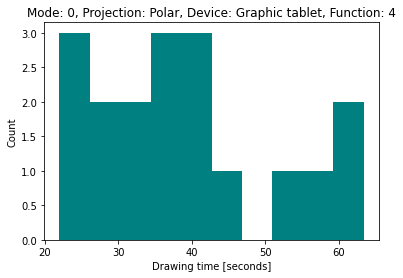

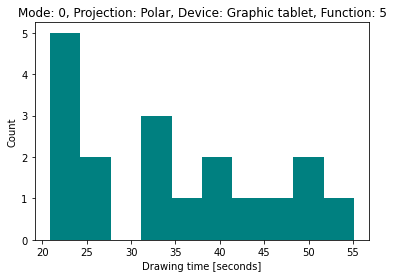

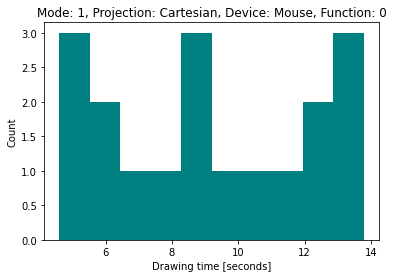

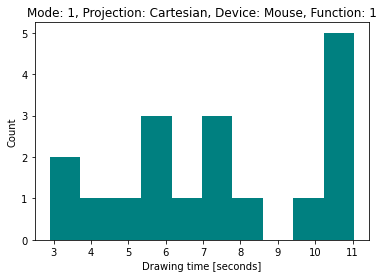

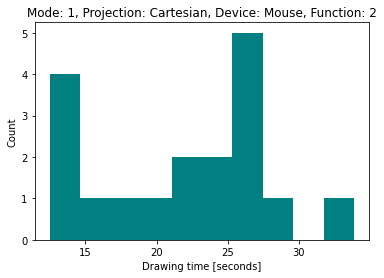

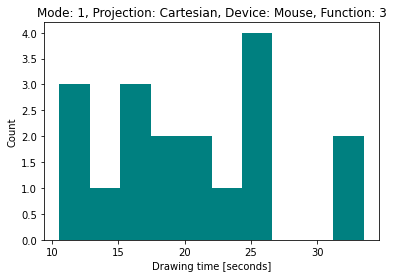

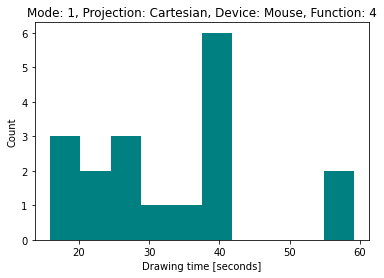

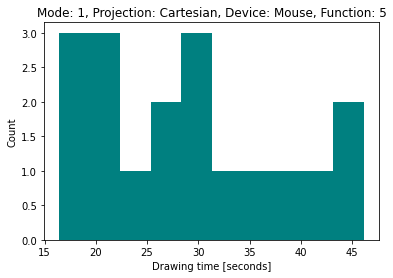

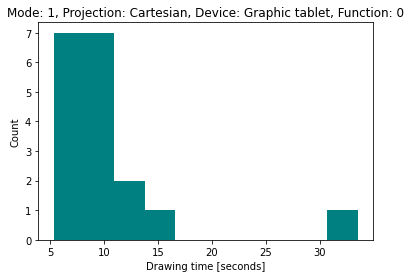

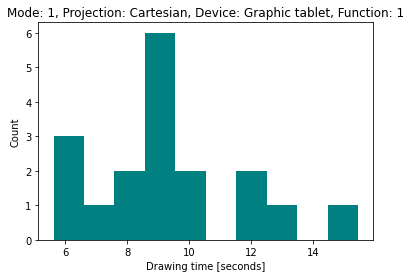

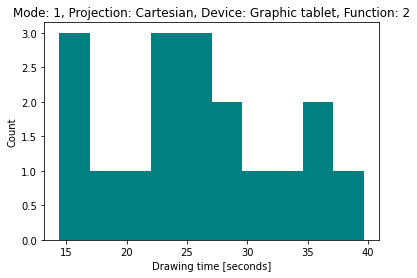

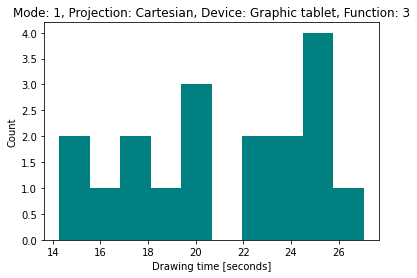

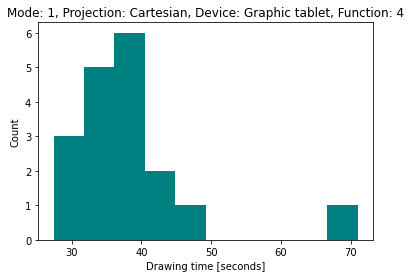

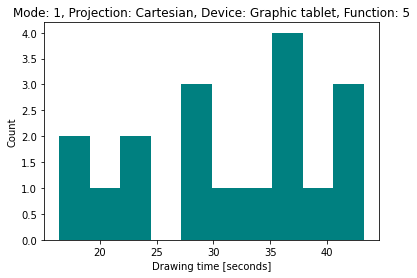

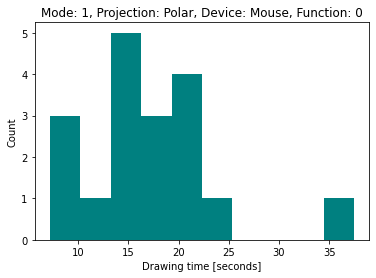

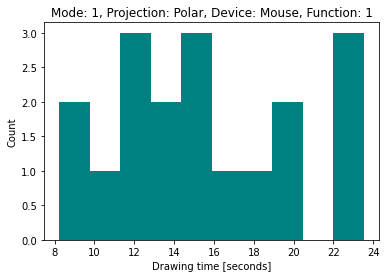

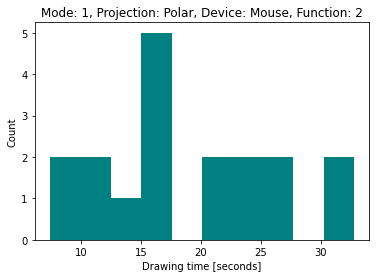

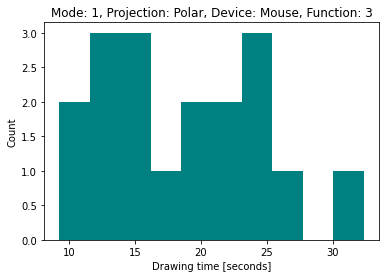

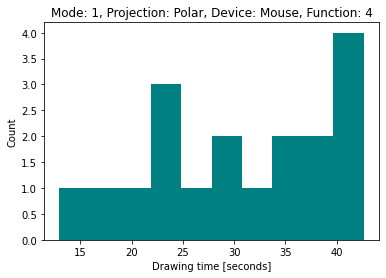

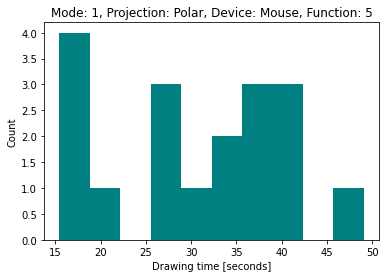

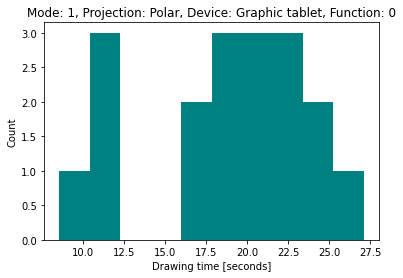

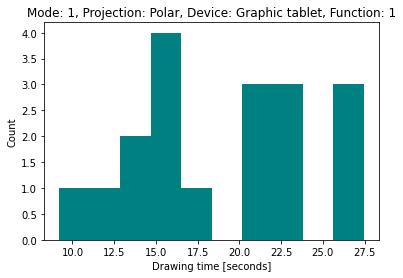

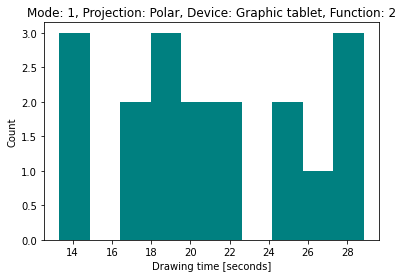

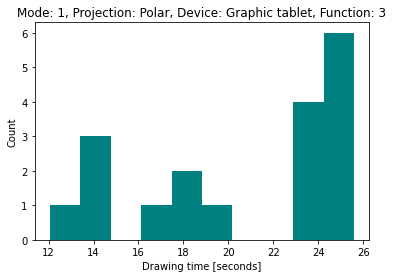

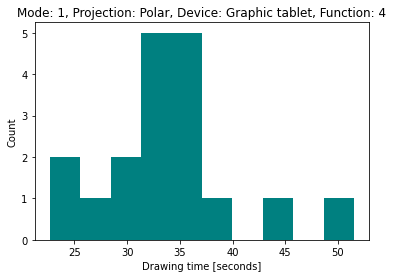

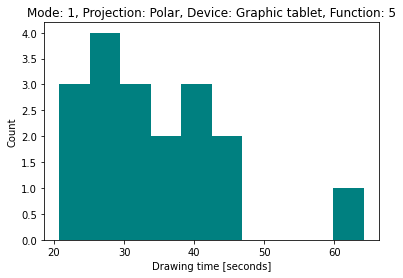

In [21]:
def getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data=df):
        # filter out by projection, Cartesian or Polar
    drawingTimes = data[data['Function projection'] == projection]
    # filter out by function ID
    drawingTimes = drawingTimes[drawingTimes['Function ID'] == funcId]
    # filter out by test (experiment mode)
    drawingTimes = drawingTimes[drawingTimes['Test mode'] == experimentMode]
    # filter out by device
    drawingTimes = drawingTimes[drawingTimes['Device'] == device]
    drawingTimes = drawingTimes['Drawing time'].values
    
    return drawingTimes

projection = "Polar"
funcId = 0
device = "Mouse"
experimentMode = 0

for experimentMode in TEST_MODES:
    for projection in PROJECTIONS:
        for device in DEVICES:
            for funcId in FUNC_IDS:
                dts = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode)

                plt.figure()
                plt.hist(dts, color="teal")
                plt.title(
                    "Mode: %s, Projection: %s, Device: %s, Function: %s"
                     % (experimentMode, projection, device, funcId)
                )
                plt.ylabel("Count")
                plt.xlabel("Drawing time [seconds]")
                plt.show()



# Average drawing time for each curve on each input device

In [22]:
def getAvgForFunc(projection, funcId, device, experimentMode = 0, data=df):
    drawingTimes = getAllDrawingTimesForFunc(projection, funcId, device, experimentMode, data)
    
    avg = np.median(drawingTimes)
    
    return avg

def getAvgsByFilter(projections, funcIds, devices, experimentModes, data=df):
    times = []
    for experimentMode in experimentModes:
        for device in devices:
            for projection in projections:
                for funcId in funcIds:
                    avg = getAvgForFunc(projection, funcId, device, experimentMode, data)
                    times.append(avg)
    return times

# for mode in TEST_MODES:
#    print("----------------- MODE:", mode)
#    for device in DEVICES:
#        print(":::", device, ":::")
#        for funcId in FUNC_IDS:
#            print("--> Function: ", funcId)
#            for projection in PROJECTIONS:
#                avg = getAvgForFunc(projection, funcId, device, mode)
#                print("\t", projection, ": ", avg)


# Test plots

In [23]:
def plotForExperiment(experimentModes, projections = PROJECTIONS):
    for experimentMode in experimentModes:
        for device in devices:
            plt.figure()
            for projection in projections: 
                times = []
                for funcId in funcIds:
                    times.append(getAvgForFunc(projection, funcId, device, experimentMode))

                iods = (getIodsAsArray([projection], [experimentMode]))
                plt.scatter(iods, times, label=projection)


            plt.ylabel("Drawing time (s)")
            plt.xlabel("Index of difficulty")
            plt.ylim([0, 50])
            plt.xlim([0, 31])
            plt.legend(loc='upper left')
            plt.title("Experiment %d, %s, %s" %(experimentMode, device, projections) )
            plt.show()

## Test plots

In [24]:
# plotForExperiment([0, 1])

# Linear regression

In [60]:
def getRegressionCoefficients(reg):
    x1 = 0
    x2 = 1
    y1, y2 = reg.predict(np.array([[x1], [x2]]))
    # Coefficients: y = ax + b
    b = y1
    a = (y2 - y1) / (x2 - x1)
    return a, b

def getDataForRegression(projections, experimentModes, device):
    iods = getIodsAsArray(projections, experimentModes)
    x = [[iod] for iod in iods]

    y = np.array(getAvgsByFilter(projections, FUNC_IDS, [device], experimentModes))
    return x, y

def getRegressionModel(projections, experimentModes, device):
    x, y = getDataForRegression(projections, experimentModes, device)
    reg = LinearRegression().fit(x, y)
    plotDataAndReg(reg, x, y, "Linear regression for %s, %s" %(projections, device))
    print("\tR^2 =", round(reg.score(x, y), 3))

    return reg

def plotDataAndReg(reg, x, y, title):
    plt.figure()
    plt.scatter(x, y, label="Experiment data", color="crimson")

    predictX = np.linspace(1, 30, 10)
    predictY = reg.predict([[x] for x in predictX])
    plt.plot(predictX, predictY, color="black", label="Linear regression")
    
    plt.ylabel("Drawing time (seconds)")
    plt.xlabel("Index of difficulty")
    plt.ylim([0, 50])
    plt.xlim([0, 31])
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    a, b = getRegressionCoefficients(reg)
    print("\ty = %.2fx + %.2f" % (a, b))

def validateRegressionModel(reg, projections, experimentModes, device):  
    x, y = getDataForRegression(projections, experimentModes, device)
    plotDataAndReg(reg, x, y, "Validated linear regression for %s, %s" %(projections, device))
    
    print("\tR^2 =", round(reg.score(x, y), 3))


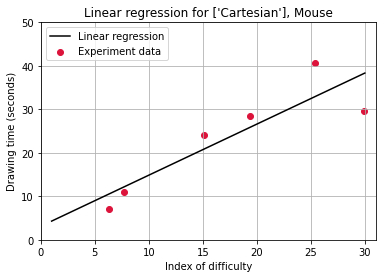

	y = 1.17x + 3.12
	R^2 = 0.787


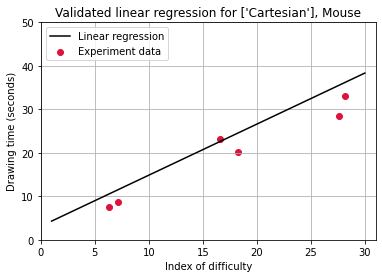

	y = 1.17x + 3.12
	R^2 = 0.822


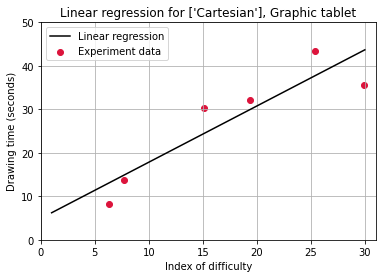

	y = 1.29x + 4.92
	R^2 = 0.821


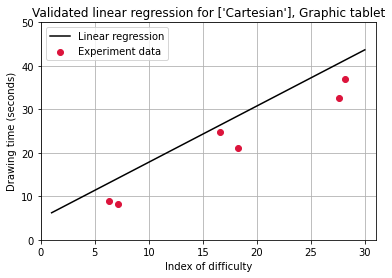

	y = 1.29x + 4.92
	R^2 = 0.725


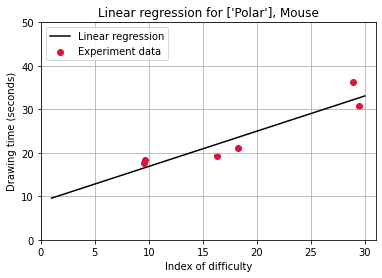

	y = 0.81x + 8.77
	R^2 = 0.874


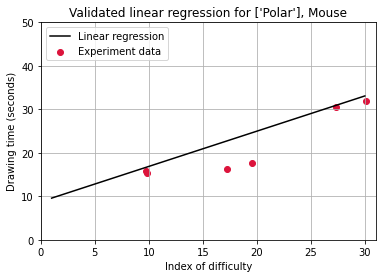

	y = 0.81x + 8.77
	R^2 = 0.683


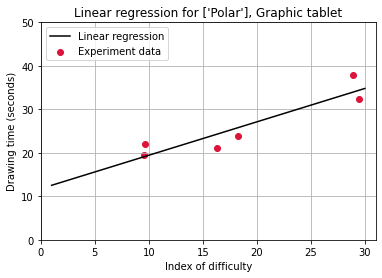

	y = 0.77x + 11.76
	R^2 = 0.846


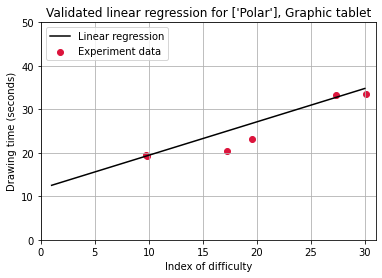

	y = 0.77x + 11.76
	R^2 = 0.842


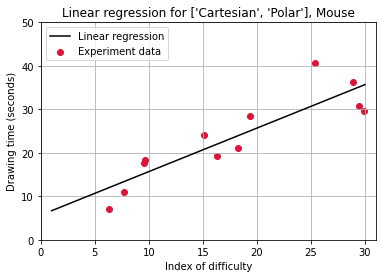

	y = 1.00x + 5.69
	R^2 = 0.783


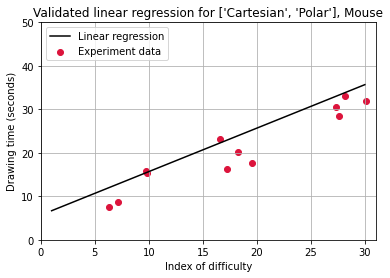

	y = 1.00x + 5.69
	R^2 = 0.763


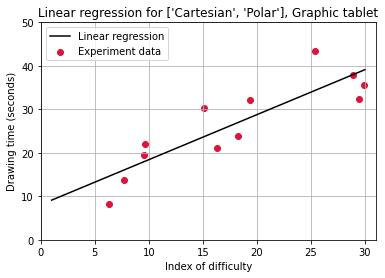

	y = 1.03x + 8.08
	R^2 = 0.762


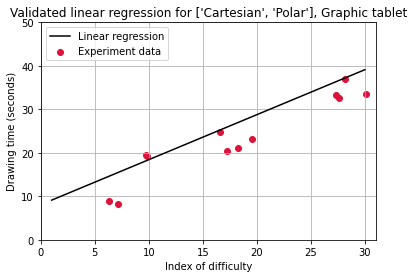

	y = 1.03x + 8.08
	R^2 = 0.753


In [61]:
for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
    for device in DEVICES:
        reg = getRegressionModel(projections, [0], device)
        validateRegressionModel(reg, projections, [1], device)


# Participant data

Number of participants: 9
Average participant age: 23.111
Standard deviation: 1.523

 ::::
Number of left handed participants: 1
Percentage of left handed participants 0.111 %

 ::::
Number of expert graphic tablet participants: 2
Percentage of expert graphic tablet participants 0.222 %

 ::::
Average drawing times
Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Mouse;['Cartesian'];32.0907;16.0932
RaulAntonio Šanko;Mouse;['Cartesian'];28.0335;14.6444
Stjepan.Obad;Mouse;['Cartesian'];28.3537;14.0015
Vito Medved;Mouse;['Cartesian'];13.6568;7.4445
galebftw;Mouse;['Cartesian'];28.6147;17.0972
ivabracko;Mouse;['Cartesian'];21.2584;10.276
ivana_bacac;Mouse;['Cartesian'];20.6923;12.0706
lenanovak;Mouse;['Cartesian'];15.8093;8.2672
marin_legenda;Mouse;['Cartesian'];18.0601;8.3835


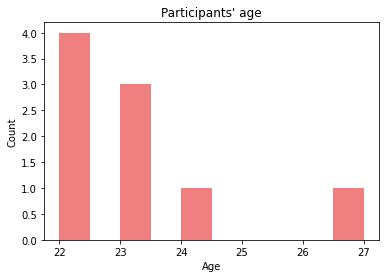

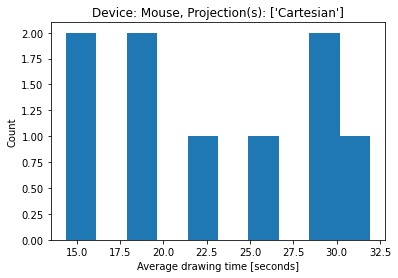

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Mouse;['Polar'];32.6096;9.2024
RaulAntonio Šanko;Mouse;['Polar'];26.1925;7.7239
Stjepan.Obad;Mouse;['Polar'];35.1631;10.9024
Vito Medved;Mouse;['Polar'];14.0075;4.4939
galebftw;Mouse;['Polar'];28.3466;12.4241
ivabracko;Mouse;['Polar'];21.8444;7.6062
ivana_bacac;Mouse;['Polar'];20.5615;7.8795
lenanovak;Mouse;['Polar'];15.183;5.7809
marin_legenda;Mouse;['Polar'];20.8713;6.5298


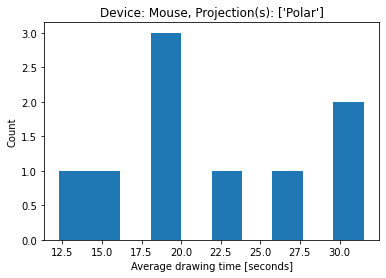

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Mouse;['Cartesian', 'Polar'];32.3502;13.1113
RaulAntonio Šanko;Mouse;['Cartesian', 'Polar'];27.113;11.7434
Stjepan.Obad;Mouse;['Cartesian', 'Polar'];31.7584;13.0017
Vito Medved;Mouse;['Cartesian', 'Polar'];13.8321;6.1513
galebftw;Mouse;['Cartesian', 'Polar'];28.4807;14.945
ivabracko;Mouse;['Cartesian', 'Polar'];21.5514;9.045
ivana_bacac;Mouse;['Cartesian', 'Polar'];20.6269;10.193
lenanovak;Mouse;['Cartesian', 'Polar'];15.4961;7.1401
marin_legenda;Mouse;['Cartesian', 'Polar'];19.4657;7.6444


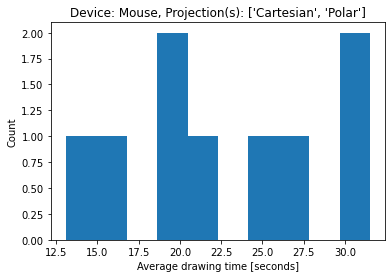

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Graphic tablet;['Cartesian'];39.4087;19.7975
RaulAntonio Šanko;Graphic tablet;['Cartesian'];27.6629;12.1565
Stjepan.Obad;Graphic tablet;['Cartesian'];26.1018;14.0084
Vito Medved;Graphic tablet;['Cartesian'];15.6925;8.5263
galebftw;Graphic tablet;['Cartesian'];33.2012;18.2352
ivabracko;Graphic tablet;['Cartesian'];28.0756;13.8179
ivana_bacac;Graphic tablet;['Cartesian'];22.908;11.1429
lenanovak;Graphic tablet;['Cartesian'];16.6658;7.6864
marin_legenda;Graphic tablet;['Cartesian'];22.2847;10.328


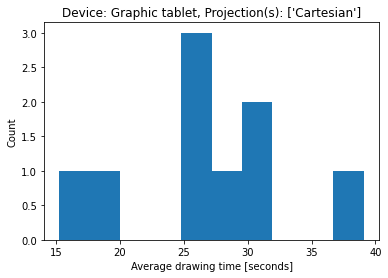

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Graphic tablet;['Polar'];37.9148;11.4791
RaulAntonio Šanko;Graphic tablet;['Polar'];27.4069;7.4452
Stjepan.Obad;Graphic tablet;['Polar'];30.1697;7.0918
Vito Medved;Graphic tablet;['Polar'];15.5914;4.9244
galebftw;Graphic tablet;['Polar'];33.8455;10.9492
ivabracko;Graphic tablet;['Polar'];24.8475;8.1533
ivana_bacac;Graphic tablet;['Polar'];23.8609;7.2767
lenanovak;Graphic tablet;['Polar'];17.1981;6.124
marin_legenda;Graphic tablet;['Polar'];23.0898;5.5118


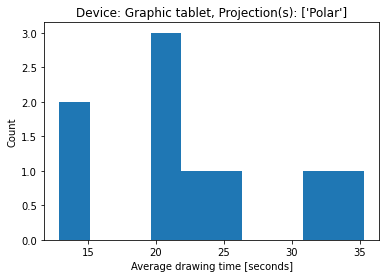

Participant;Device;Projections;Drawing Time Mean;Drawing time variance
Karolina Skunca;Graphic tablet;['Cartesian', 'Polar'];38.6618;16.1991
RaulAntonio Šanko;Graphic tablet;['Cartesian', 'Polar'];27.5349;10.0808
Stjepan.Obad;Graphic tablet;['Cartesian', 'Polar'];28.1357;11.2872
Vito Medved;Graphic tablet;['Cartesian', 'Polar'];15.642;6.9625
galebftw;Graphic tablet;['Cartesian', 'Polar'];33.5233;15.0436
ivabracko;Graphic tablet;['Cartesian', 'Polar'];26.4615;11.4591
ivana_bacac;Graphic tablet;['Cartesian', 'Polar'];23.3844;9.4226
lenanovak;Graphic tablet;['Cartesian', 'Polar'];16.9319;6.9543
marin_legenda;Graphic tablet;['Cartesian', 'Polar'];22.6872;8.2877


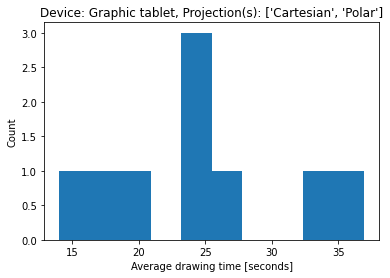

In [78]:
participants = list(set(test0data['Participant name']))

print("Number of participants:", len(participants))

ages = []
leftHanded = 0
hasExpWTablet = 0
for participant in participants:
    row = df[df['Participant name'] == participant]
    age = row['Participant age'].values[0]
    leftHanded += row['Is Left handed'].values[0]
    hasExpWTablet += row['Experienced Graphic Tablet User'].values[0]
    # print(participant, age)
    ages.append(age)

plt.figure()
plt.hist(ages, color="lightcoral")
plt.ylabel("Count")
plt.xlabel("Age")
plt.title("Participants' age")
plt.plot
print("Average participant age:", round(np.mean(ages), 3))
print("Standard deviation:", round(np.std(ages), 3))

print("\n ::::")
print("Number of left handed participants:", leftHanded)
print("Percentage of left handed participants", round(leftHanded * 1.0 / len(participants), 3), '%')

print("\n ::::")
print("Number of expert graphic tablet participants:", hasExpWTablet)
print("Percentage of expert graphic tablet participants",
      round(hasExpWTablet * 1.0 / len(participants), 3), '%'
    )


print("\n ::::")
print("Average drawing times")
# Average drawing time per user
sortedParticipants = sorted(participants)
for device in DEVICES:
    for projections in [["Cartesian"], ["Polar"], PROJECTIONS]:
        pltData = []
        print("Participant","Device", "Projections","Drawing Time Mean", "Drawing time variance", sep=";")
        for i in range(len(sortedParticipants)):
            participant = sortedParticipants[i]
            dts = []
            for funcId in FUNC_IDS:
                for experimentMode in TEST_MODES:
                    drawingTimes = df[df['Participant name'] == participant]
                    drawingTimes = getAvgsByFilter(projections, [funcId], [device], [experimentMode], drawingTimes)
                    dts.append(drawingTimes)
            print(participant, device, projections, round(np.mean(dts), 4), round(np.std(dts), 4), sep=';')
            pltData.append(np.median(dts))
        # print()
        plt.figure()
        plt.hist(pltData)
        plt.title("Device: %s, Projection(s): %s" %(device, projections))
        plt.ylabel("Count")
        plt.xlabel("Average drawing time [seconds]")
        plt.show()
            


## Error approximation

Participant index, Mouse mean, Mouse stdev, Graphic tablet mean, Graphic tablet stdev
Karolina Skunca,0.021434,0.01185,0.025392,0.011798
RaulAntonio Šanko,0.02771,0.012669,0.031797,0.014146
Stjepan.Obad,0.025426,0.012296,0.038225,0.016655
Vito Medved,0.033455,0.016245,0.040499,0.019324
galebftw,0.02738,0.015948,0.028375,0.014004
ivabracko,0.027046,0.011715,0.029147,0.013854
ivana_bacac,0.029027,0.015113,0.032119,0.016288
lenanovak,0.030477,0.01592,0.033633,0.015806
marin_legenda,0.039117,0.021025,0.04131,0.020048


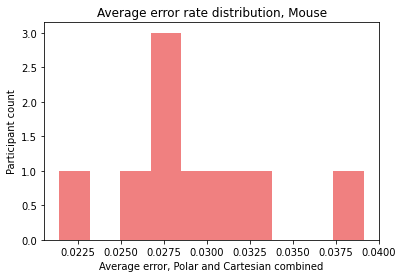

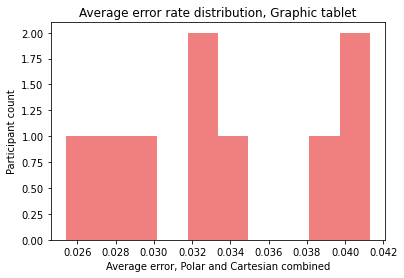

In [77]:
sortedParticipants = sorted(participants)

print("Participant index, Mouse mean, Mouse stdev, Graphic tablet mean, Graphic tablet stdev")
avgs = { "Mouse":[], "Graphic tablet":[]}
for i in range(len(sortedParticipants)):
    participant = sortedParticipants[i]
    print(participant, end='')
    for device in DEVICES:
        # epm = error per move
        epms = []
        for experimentMode in TEST_MODES:
            filename = "../Results_backup%s/%s/%s" %(experimentMode, participant, device)
            files = os.listdir(filename)
            for file in files:
                funcId = int(file[3])
                projtmp = file[10]
                projection = "Cartesian"
                if(projtmp in ["2", "3"]):
                    projection = "Polar"
                # filter out by projection, Cartesian or Polar
                errors = df[df['Function projection'] == projection]
                # filter out by function ID
                errors = errors[errors['Function ID'] == funcId]
                # filter out by test (experiment mode)
                errors = errors[errors['Test mode'] == experimentMode]
                errors = errors[errors['Participant name'] == participant]
                # filter out by device
                errors = errors[errors['Device'] == device]
                f = open(filename + "/" + file)
                
                errorVal = np.mean(errors["Error approx"].values) * 1.0 / len(f.readlines())
                epms.append(errorVal)
                f.close()
                # print(participant, projection, "(%s)" %projtmp, experimentMode, funcId, device, errorVal)
        print('', round(np.mean(epms), 6), round(np.std(epms), 6), sep=",", end='')
        avgs[device].append(np.mean(epms))
    print()

plt.figure()
plt.hist(avgs["Mouse"], color="lightcoral")
plt.title("Average error rate distribution, Mouse")
plt.xlabel("Average error, Polar and Cartesian combined")
plt.ylabel("Participant count")
plt.show()

plt.figure()
plt.hist(avgs["Graphic tablet"], color="lightcoral")
plt.title("Average error rate distribution, Graphic tablet")
plt.xlabel("Average error, Polar and Cartesian combined")
plt.ylabel("Participant count")
plt.show()